In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import sunkit_image
import sunkit_image.coalignment as coalignment
import sunkit_image.enhance as enhance
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import h5py

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   
from glob import glob
import cv2
import flow_vis



In [2]:
eui_files = sorted(glob("../../src/EUI/HRI/euv174/20221024/solo_L2_eui-hri*.fits"))

In [3]:
eui_map_all = sunpy.map.Map(eui_files[171:182], sequence=True, memmap=True)
eui_centers = [m.center for m in eui_map_all]

In [4]:
with h5py.File("../../src/EUI/HRI/euv174/20221024/coalign_shifts_step.h5","r") as f:
    eui_map_seq_coalign_shifts_x = f["x"][()]
    eui_map_seq_coalign_shifts_y = f["y"][()]
eui_map_seq_coalign_shifts = {"x":eui_map_seq_coalign_shifts_x[171:182]*u.arcsec,"y":eui_map_seq_coalign_shifts_y[171:182]*u.arcsec}

In [5]:
eui_map_seq_coalign = coalignment.mapsequence_coalign_by_match_template(eui_map_all,shift=eui_map_seq_coalign_shifts)

In [6]:
Txshift_hri, Tyshift_hri = (1.66986 + 2.49223)*u.arcsec,(7.60204 - 2.76366 )*u.arcsec

In [7]:
eis_195_velmap_derot_repro_shifted_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")
eis_hhflare_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_derot_repro_hrifov.fits")

In [8]:
eui_map_181 = eui_map_seq_coalign[-1].shift_reference_coord(Txshift_hri,Tyshift_hri)
eui_map_181.meta["rsun_ref"] = 696000000.0
eui_wcs_all = eui_map_181.wcs

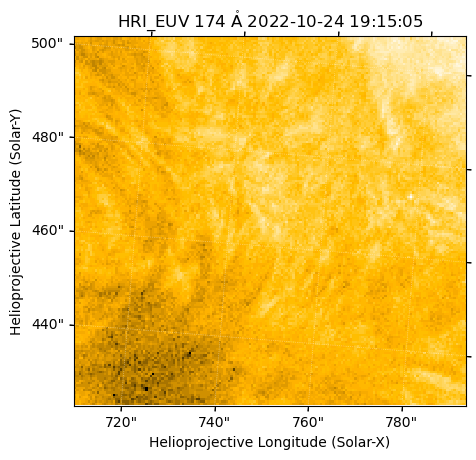

In [9]:
eui_map_181_east_1 = eui_map_181.submap([500,600]*u.pix,
                                        top_right=[670,760]*u.pix)
eui_map_181_east_1.plot()

In [10]:
eui_map_181_east_1_fake = eui_map_181.submap([490,590]*u.pix,
                                        top_right=[660,750]*u.pix)
eui_map_181_east_1_fake = sunpy.map.Map(eui_map_181_east_1_fake.data,eui_map_181_east_1.meta)

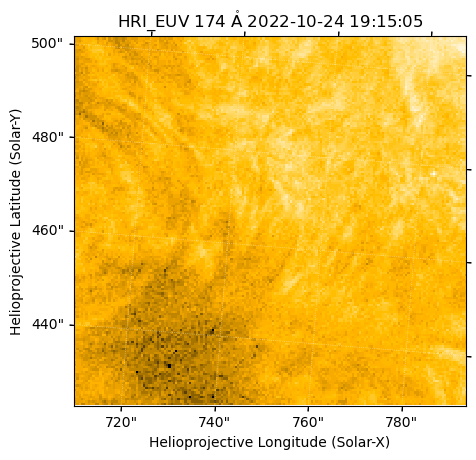

In [11]:
eui_map_181_east_1_fake.plot()

In [84]:
def calc_dense_optical_flow_farneback(mapseq, bottom_left=None, top_right=None,
                                      params=[0.5, 3, 15, 3, 5, 1.2, 0],upsample=None):
    for ii in range(len(mapseq)-1):
        if bottom_left is None:
            map_prev = mapseq[ii]
            map_next = mapseq[ii+1]
        else:
            map_prev = mapseq[ii].submap(bottom_left, top_right=top_right)
            map_next = mapseq[ii+1].submap(bottom_left, top_right=top_right)

        if upsample is not None:
            map_prev = map_prev.resample(u.Quantity(np.array(map_prev.data.shape)*upsample*u.pix))
            map_next = map_next.resample(u.Quantity(np.array(map_next.data.shape)*upsample*u.pix))
            
        prev = cv2.normalize(map_prev.data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        next = cv2.normalize(map_next.data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        flow = cv2.calcOpticalFlowFarneback(prev, next, None,*params)
        flow = flow - np.nanmedian(flow,axis=(0,1))
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

    
        if ii == 0:
            flow_all = np.zeros((len(mapseq)-1,flow.shape[0],flow.shape[1],4))
        flow_all[ii,:,:,:2] = flow
        flow_all[ii,:,:,2] = mag
        flow_all[ii,:,:,3] = ang

    return flow_all, map_prev

In [66]:
def calc_dense_optical_flow_lucaskanade_dense(mapseq, bottom_left=None, top_right=None,rebin=None):
    for ii in range(len(mapseq)-1):
        if bottom_left is None:
            map_prev = mapseq[ii]
            map_next = mapseq[ii+1]
        else:
            map_prev = mapseq[ii].submap(bottom_left, top_right=top_right)
            map_next = mapseq[ii+1].submap(bottom_left, top_right=top_right)

        if rebin is not None:
            map_prev = map_prev.resample(u.Quantity(np.array(map_prev.data.shape)//2*u.pix))
            map_next = map_next.resample(u.Quantity(np.array(map_next.data.shape)//2*u.pix))
            
        prev = cv2.normalize(map_prev.data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        next = cv2.normalize(map_next.data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        flow = cv2.optflow.calcOpticalFlowSparseToDense(prev, next, None,)
        flow = flow - np.nanmedian(flow,axis=(0,1))
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

    
        if ii == 0:
            flow_all = np.zeros((len(mapseq)-1,flow.shape[0],flow.shape[1],4))
        flow_all[ii,:,:,:2] = flow
        flow_all[ii,:,:,2] = mag
        flow_all[ii,:,:,3] = ang

    return flow_all, map_prev

In [75]:
def calc_dense_optical_flow_SF(mapseq, bottom_left=None, top_right=None,rebin=None,
                               params=[5,15,5]):
    for ii in range(len(mapseq)-1):
        if bottom_left is None:
            map_prev = mapseq[ii]
            map_next = mapseq[ii+1]
        else:
            map_prev = mapseq[ii].submap(bottom_left, top_right=top_right)
            map_next = mapseq[ii+1].submap(bottom_left, top_right=top_right)

        if rebin is not None:
            map_prev = map_prev.resample(u.Quantity(np.array(map_prev.data.shape)//2*u.pix))
            map_next = map_next.resample(u.Quantity(np.array(map_next.data.shape)//2*u.pix))
            
        prev = cv2.normalize(map_prev.data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        next = cv2.normalize(map_next.data, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        flow = cv2.optflow.calcOpticalFlowSF(prev, next, *params, None)
        flow = flow - np.nanmedian(flow,axis=(0,1))
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

    
        if ii == 0:
            flow_all = np.zeros((len(mapseq)-1,flow.shape[0],flow.shape[1],4))
        flow_all[ii,:,:,:2] = flow
        flow_all[ii,:,:,2] = mag
        flow_all[ii,:,:,3] = ang

    return flow_all, map_prev

In [85]:
optical_flow_east_1, _ = calc_dense_optical_flow_farneback(sunpy.map.Map([eui_map_181_east_1,eui_map_181_east_1_fake]))

In [40]:
optical_flow_east_1.shape

(1, 161, 171, 4)

In [41]:
optical_flow_east_1_0_mag, optical_flow_east_1_0_ang = cv2.cartToPolar(optical_flow_east_1[0,:,:,0], optical_flow_east_1[0,:,:,1])

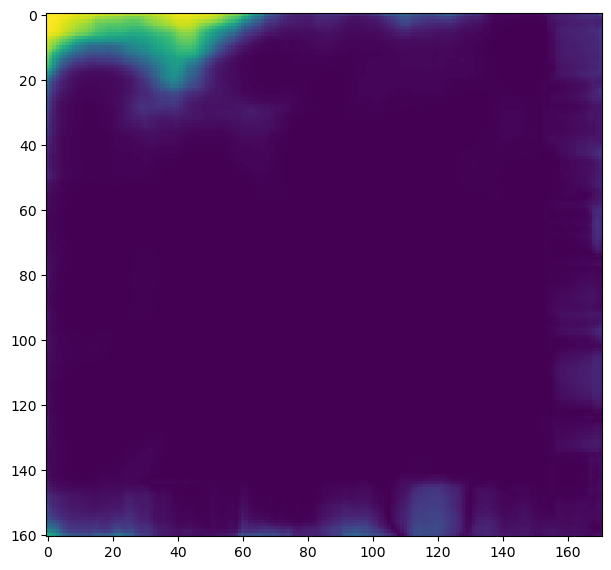

In [42]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

ax.imshow(optical_flow_east_1_0_mag, cmap='viridis')

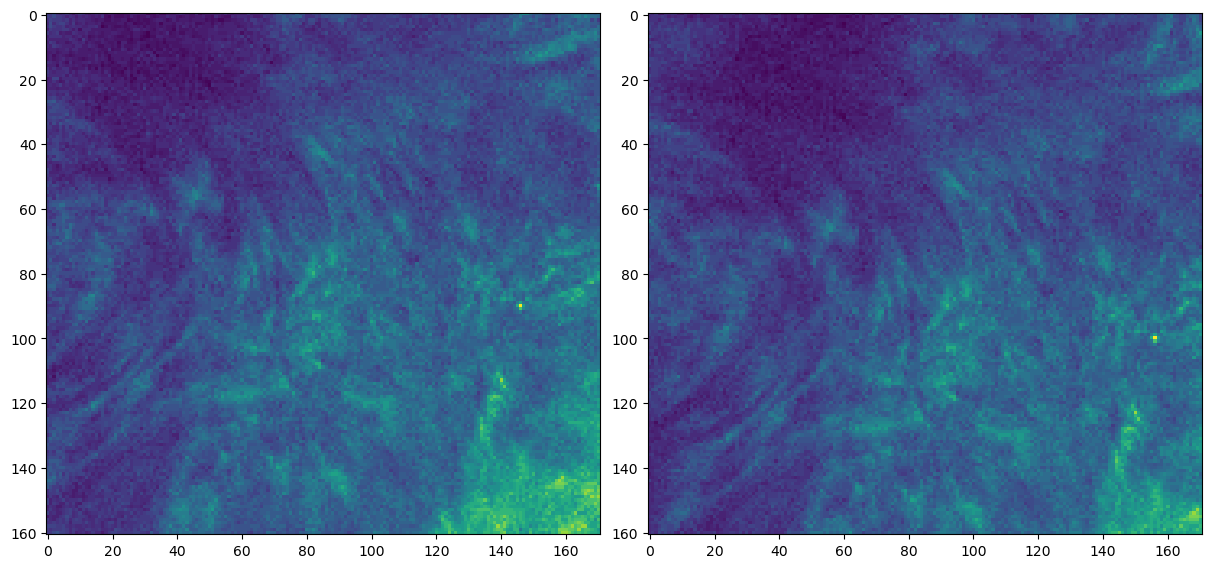

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6),layout='constrained')

ax1.imshow(eui_map_181_east_1.data)

ax2.imshow(eui_map_181_east_1_fake.data)

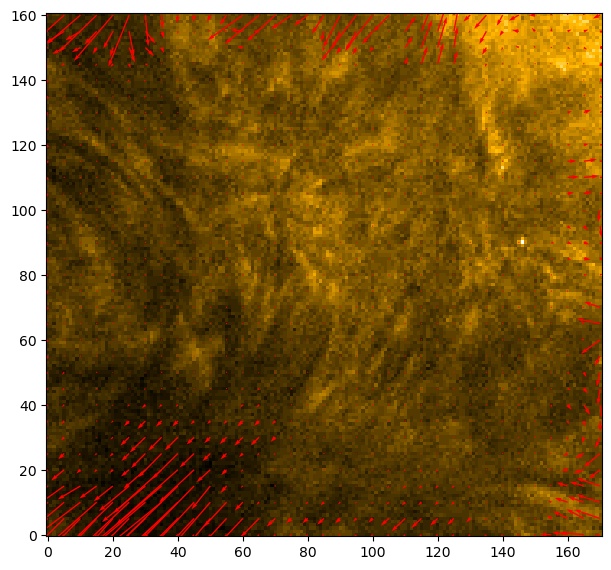

In [45]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

ax.imshow(eui_map_181_east_1.data, cmap='solar orbiterhri_euv174',origin='lower')
ax.quiver(np.arange(0,optical_flow_east_1.shape[2],5),np.arange(0,optical_flow_east_1.shape[1],5),
          optical_flow_east_1[0,::5,::5,0],optical_flow_east_1[0,::5,::5,1],color='r')

In [86]:
optical_flow_east_1_test, _ = calc_dense_optical_flow_farneback(eui_map_seq_coalign, bottom_left=[500,600]*u.pix,top_right=[670,760]*u.pix,)
optical_flow_east_1_test_2, _ = calc_dense_optical_flow_farneback(eui_map_seq_coalign, bottom_left=[500,600]*u.pix,top_right=[670,760]*u.pix,
                                                             params=[0.5, 10, 20, 10, 5, 1.1, 0])
optical_flow_east_1_test_3, optical_flow_east_1_test_3_map = calc_dense_optical_flow_farneback(eui_map_seq_coalign, bottom_left=[500,600]*u.pix,top_right=[670,760]*u.pix,
                                                               upsample=8,params=[0.5, 5, 20, 10, 5, 1.1, 0])
optical_flow_east_1_lk, _ = calc_dense_optical_flow_lucaskanade_dense(eui_map_seq_coalign, bottom_left=[500,600]*u.pix,top_right=[670,760]*u.pix)

optical_flow_east_1_sf, _ = calc_dense_optical_flow_SF(eui_map_seq_coalign, bottom_left=[500,600]*u.pix,top_right=[670,760]*u.pix,
                                                       params=[3,2,5])

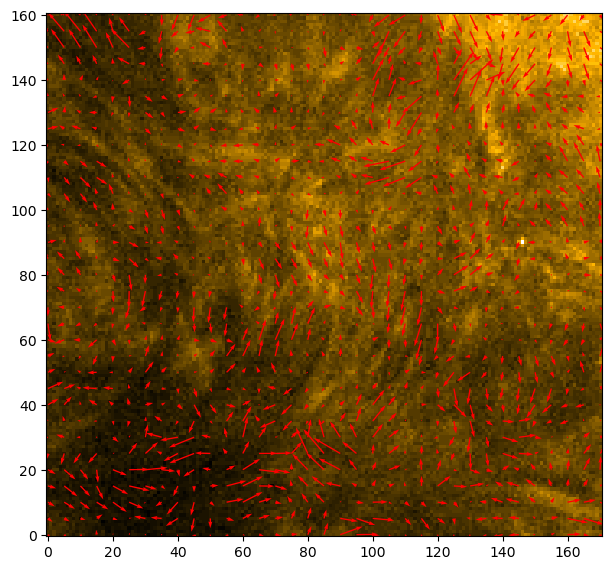

In [49]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

ax.imshow(eui_map_181_east_1.data, cmap='solar orbiterhri_euv174',origin='lower')
ax.quiver(np.arange(0,optical_flow_east_1_test.shape[2],5),np.arange(0,optical_flow_east_1_test.shape[1],5),
          optical_flow_east_1_test[0,::5,::5,0],optical_flow_east_1_test[0,::5,::5,1],color='r')

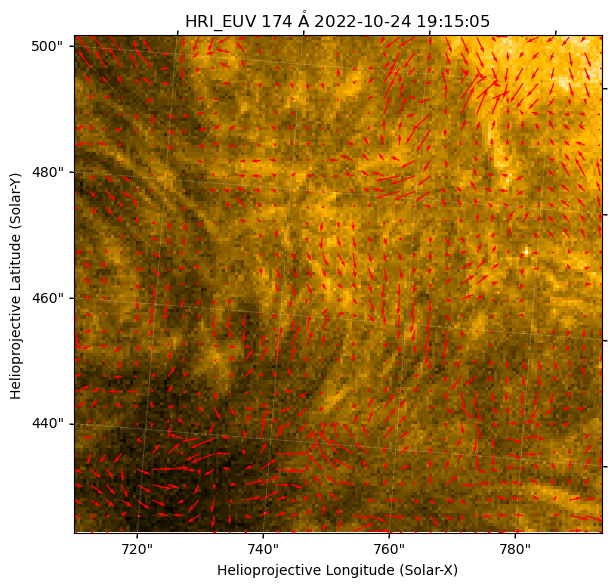

In [22]:
fig = plt.figure(figsize=(6,6),layout='constrained')

ax = fig.add_subplot(111,projection=eui_map_181_east_1,)

eui_map_181_east_1.plot(axes=ax,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))

ax.quiver(np.arange(0,optical_flow_east_1_test.shape[2],5),np.arange(0,optical_flow_east_1_test.shape[1],5),
            optical_flow_east_1_test[0,::5,::5,0],optical_flow_east_1_test[0,::5,::5,1],color='r')

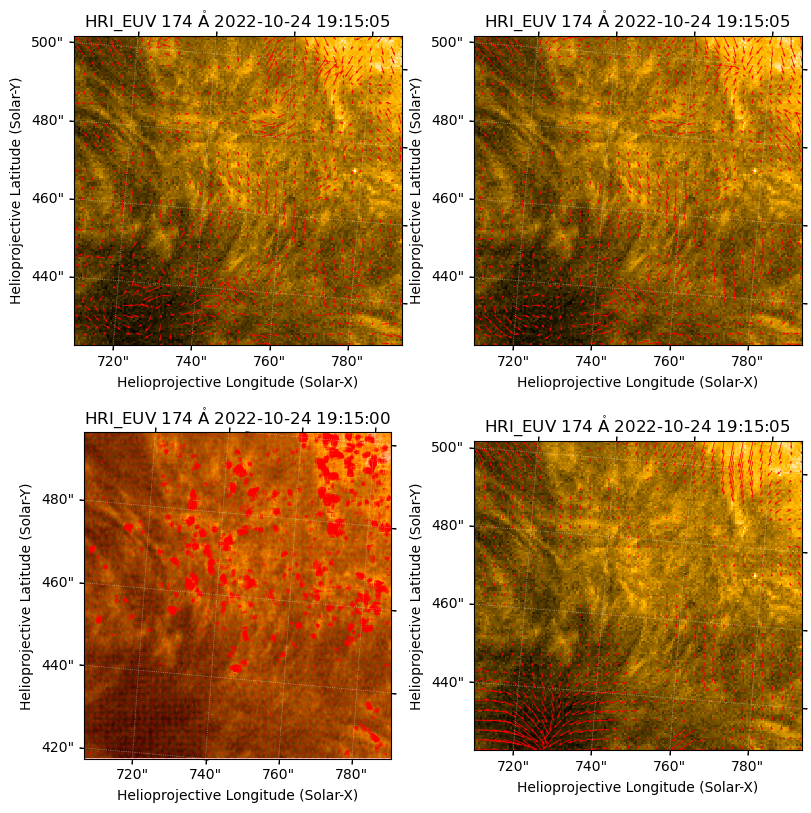

In [87]:
fig = plt.figure(figsize=(8,8),layout='constrained')

ax1 = fig.add_subplot(221,projection=eui_map_181_east_1,)
ax2 = fig.add_subplot(222,projection=eui_map_181_east_1,)
ax3 = fig.add_subplot(223,projection=optical_flow_east_1_test_3_map)
ax4 = fig.add_subplot(224,projection=eui_map_181_east_1)

eui_map_181_east_1.plot(axes=ax1,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))
eui_map_181_east_1.plot(axes=ax2,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))
optical_flow_east_1_test_3_map.plot(axes=ax3,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))
eui_map_181_east_1.plot(axes=ax4,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))

ax1.quiver(np.arange(0,optical_flow_east_1_test.shape[2],5),np.arange(0,optical_flow_east_1_test.shape[1],5),
            optical_flow_east_1_test[0,::5,::5,0],optical_flow_east_1_test[0,::5,::5,1],color='r')

ax2.quiver(np.arange(0,optical_flow_east_1_test_2.shape[2],5),np.arange(0,optical_flow_east_1_test_2.shape[1],5),
            optical_flow_east_1_test_2[0,::5,::5,0],optical_flow_east_1_test_2[0,::5,::5,1],color='r')

ax3.quiver(np.arange(0,optical_flow_east_1_test_3.shape[2],5),np.arange(0,optical_flow_east_1_test_3.shape[1],5),
            optical_flow_east_1_test_3[0,::5,::5,0],optical_flow_east_1_test_3[0,::5,::5,1],color='r')

ax4.quiver(np.arange(0,optical_flow_east_1_lk.shape[2],5),np.arange(0,optical_flow_east_1_lk.shape[1],5),
            optical_flow_east_1_lk[0,::5,::5,0],optical_flow_east_1_lk[0,::5,::5,1],color='r')

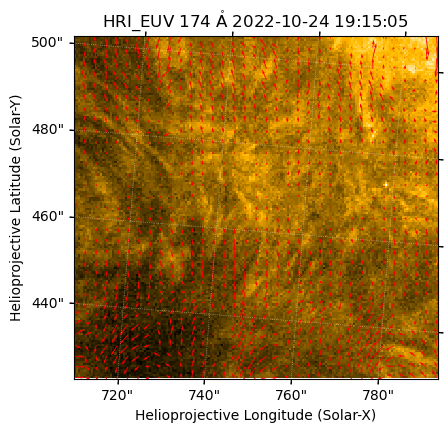

In [83]:
fig = plt.figure(figsize=(8,8),layout='constrained')

ax1 = fig.add_subplot(221,projection=eui_map_181_east_1,)


eui_map_181_east_1.plot(axes=ax1,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))

ax1.quiver(np.arange(0,optical_flow_east_1_sf.shape[2],5),np.arange(0,optical_flow_east_1_sf.shape[1],5),
            optical_flow_east_1_sf[0,::5,::5,0],optical_flow_east_1_sf[0,::5,::5,1],color='r')

In [24]:
def mag_ang_to_rgb(mag, ang):
    hsv = np.zeros((mag.shape[0],mag.shape[1],3),dtype=np.uint8)
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,1] = 128
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [25]:
optical_flow_east_1_test_hsv = mag_ang_to_rgb(optical_flow_east_1_test[0,:,:,2],optical_flow_east_1_test[0,:,:,3])

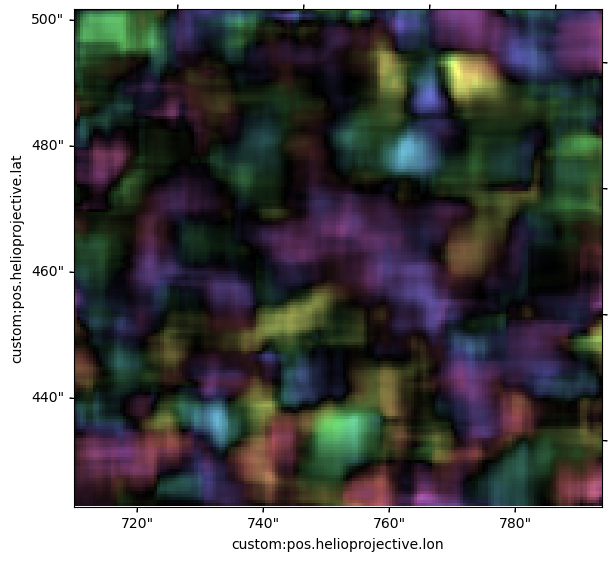

In [26]:
fig = plt.figure(figsize=(6,6),layout='constrained')

ax = fig.add_subplot(111,projection=eui_map_181_east_1,)

ax.imshow(optical_flow_east_1_test_hsv,origin="lower")

In [27]:
optical_flow_east_1_test_hsv_flow_vis = flow_vis.flow_to_color(optical_flow_east_1_test[0,:,:,:2],)

In [88]:
optical_flow_east_1_test_hsv_flow_vis_test3 = flow_vis.flow_to_color(optical_flow_east_1_test_3[0,:,:,:2],)

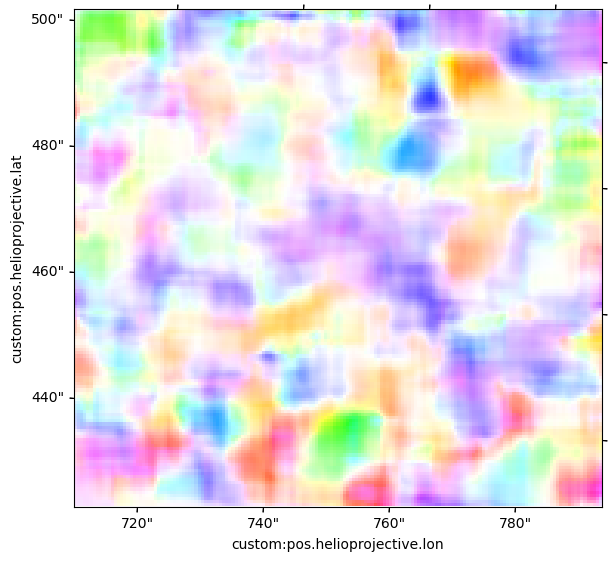

In [28]:
fig = plt.figure(figsize=(6,6),layout='constrained')

ax = fig.add_subplot(111,projection=eui_map_181_east_1,)

ax.imshow(optical_flow_east_1_test_hsv_flow_vis,origin="lower")

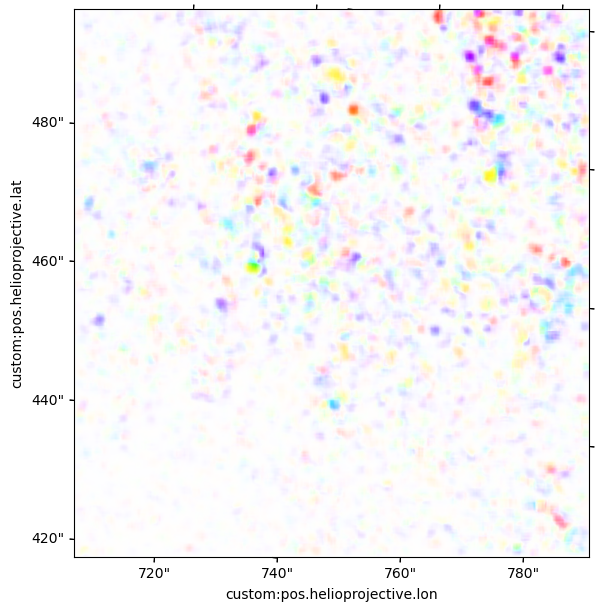

In [89]:
fig = plt.figure(figsize=(6,6),layout='constrained')

ax = fig.add_subplot(111,projection=optical_flow_east_1_test_3_map,)

ax.imshow(optical_flow_east_1_test_hsv_flow_vis_test3,origin="lower")

In [29]:
def draw_hsv_color_wheel(ax,vmin=0,vmax=1.5,samples=1024,clip_circle=True):
    xx, yy = np.meshgrid(
    np.linspace(-vmax, vmax, samples), np.linspace(-vmax, vmax, samples))

    rr = np.sqrt(xx**2 + yy**2) 

    color_wheel_rgb = flow_vis.flow_to_color(np.dstack((xx,yy)))

    if clip_circle == True:
        color_wheel_rgb[rr > vmax] = 255
        color_wheel_a = np.where(rr > vmax, 255, 255)
    else:
        color_wheel_a = np.ones(rr.shape)*255

    color_wheel_rgba = np.dstack((color_wheel_rgb,color_wheel_a))

    ax.imshow(color_wheel_rgba,extent=(-vmax,vmax,-vmax,vmax),origin="lower")

    ax.set_axis_off()

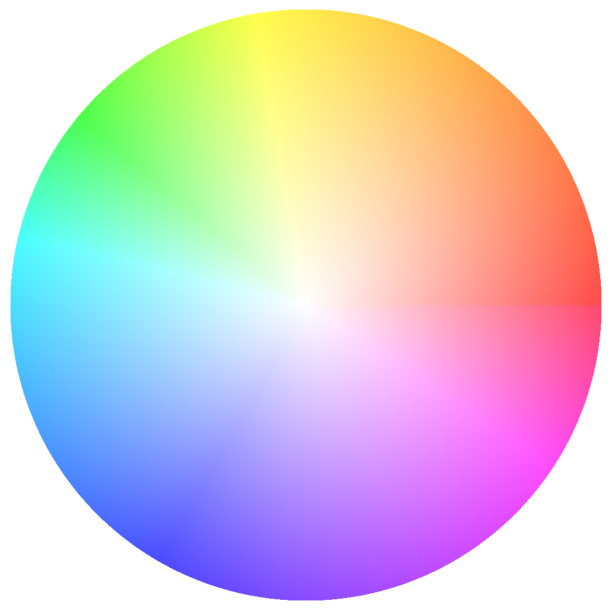

In [30]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

color_wheel_rgba = draw_hsv_color_wheel(ax,clip_circle=True)

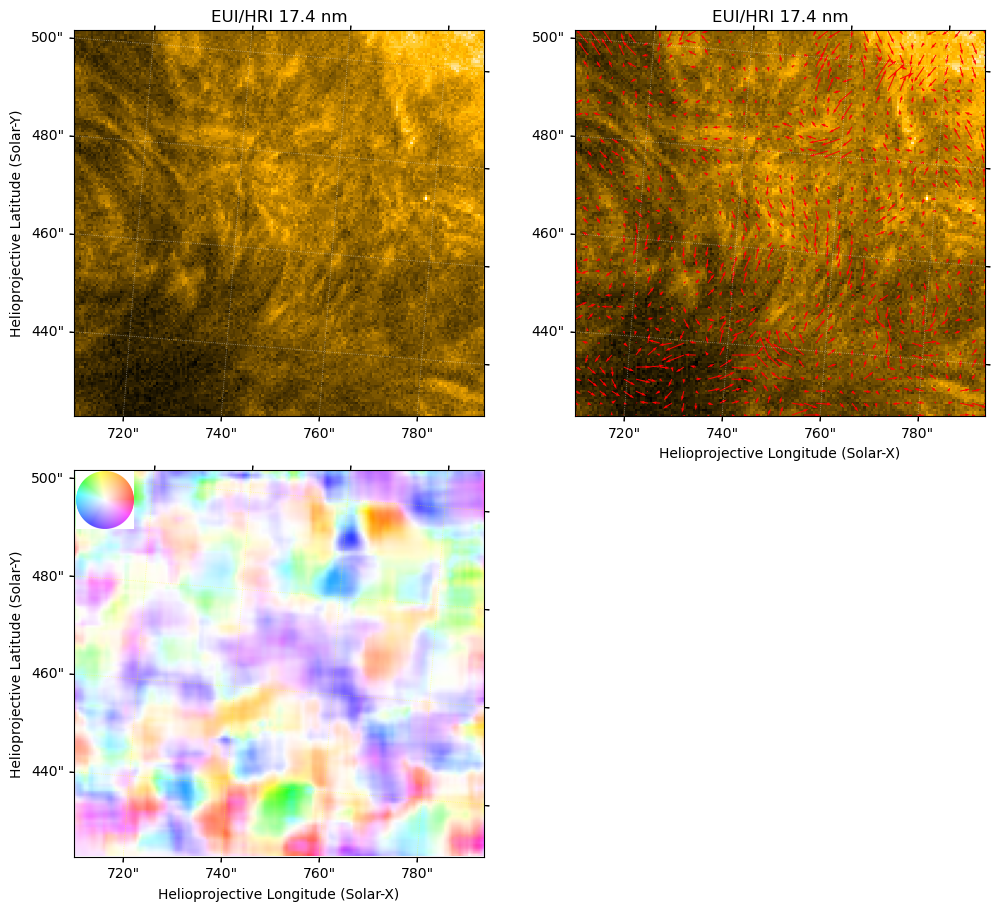

In [31]:
fig = plt.figure(figsize=(10,9),layout='constrained')

ax1 = fig.add_subplot(221,projection=eui_map_181_east_1,)

eui_map_181_east_1.plot(axes=ax1,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)),
                        title="EUI/HRI 17.4 nm")

ax2 = fig.add_subplot(222,projection=eui_map_181_east_1,)
eui_map_181_east_1.plot(axes=ax2,norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)),
                        title="EUI/HRI 17.4 nm")

ax2.quiver(np.arange(0,optical_flow_east_1_test.shape[2],5),np.arange(0,optical_flow_east_1_test.shape[1],5),
            optical_flow_east_1_test[0,::5,::5,0],optical_flow_east_1_test[0,::5,::5,1],color='r')

ax2.set_ylabel(' ')

ax3 = fig.add_subplot(223,projection=eui_map_181_east_1,)

ax3.imshow(optical_flow_east_1_test_hsv_flow_vis,origin="lower")

ax3_wheel_ax = inset_axes(ax3,width="100%",height="100%",loc="upper left",
                bbox_to_anchor=[0,0.847,0.15,0.15],
                 bbox_transform=ax3.transAxes,
                 borderpad=0)

draw_hsv_color_wheel(ax3_wheel_ax,clip_circle=True)

ax3.grid("on",lw=0.5,ls=":",color="yellow",alpha=0.5)

ax3.set_ylabel(ax1.get_ylabel())
ax3.set_xlabel(ax1.get_xlabel())

ax1.set_xlabel(' ')

# ax4 = fig.add_subplot(224,projection=eui_map_181_east_1,)

# ax4.imshow((eui_map_seq_coalign[1].data - eui_map_seq_coalign[0].data)/eui_map_se, cmap='binary',origin='lower')